## Spectral partitioning

We examine a data mining task of clustering a graph which defines a network of relationships. We collect data from a forum where posters can quote each other in reply to other posts. We define our data such that there exists a relationship between two people when they quote each other, i.e. if `A` quotes `B` in a post, then a relationship exists between `A` and `B`, and vice versa. If `C` makes a post on the thread, but does not quote anyone, then `C` has no relationship with any of the posters on the thread. 

We visualize these relationships between any two poster as a directed graph. The direction of the edges indicate who quotes who. We can define this as a relationship between `source` and `target`. A user in the `source` column has made a post and quotes the `target`. Multiple quotes have been separated into separate observations.

The overarching objective is to determine is there is any information latent in the nature of interaction on any particular thread. Some of the hypotheses include the possibility that a group of posters interact significantly more with each other and as a result form a cluster which exists somewhat independently of other groups of posters on the same thread. In any case, posters who had little or no interaction with others in the thread are very likely to stand apart from the giant cluster of active contributors.

**Collecting the data**. Here the code implements the data collection from the forum thread of interest. This code is particular to the forum of interest and will change depending on the nature of interaction with the `html` page. We use `BeautifulSoup` to extract the information residing in the tags.

In [287]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import re

In [288]:
#URL page
link = 'https://www.nairaland.com/4945611/thread-tutorial-python-programming/'

In [289]:
def getNodes(link):
    nodes = {}
    k = 0

    for i in range(27): #link has 27 pages
        url = link + str(i)
        html = requests.get(url)
        soup = BeautifulSoup(html.content)
        tnodes = {} #Temporary nodes
        print('Downloading page...',i, end='\r')
        for i, j in zip(soup.find_all('td', {'class': 'bold l pu'}), 
                       soup.find_all('td', {'class': 'l w pd'})):
            if i.find('a', {'class': 'user'}):
                tnodes['user'] = i.find('a', {'class': 'user'}).string
            else:
                tnodes['user'] = '?'
            quoted = []
            x = (j.find_all('blockquote'))
            if x == []:
                tnodes['quoted'] = []
            else:
                n = 0
                while n < len(x):
                    if x[n].a is not None:
                        if re.match(pattern='/post/\d*$', string=x[n].a['href']):
                            quoted.append(x[n].a.b.string)
                    n += 1
                tnodes['quoted'] = quoted
            nodes[k] = tnodes     
            k += 1
            tnodes = {}
    return nodes

In [290]:
mnodes = getNodes(link)

We get a dictionary which contains information about each `user` and the poster quoted given as `quoted`. A peek into the resulting dictionary shows `user`-`quoted` pairs. For posts where no one is quoted, `quoted` is an empty list, while for `user` who has `quoted` another poster, `quoted` is a list containing that poster's username. for `user` who has quoted another poster multiple times, `quoted`, which is defined as a list, contains all of the posters that have been quoted. '?' is used to indicate unavailable posters.

In [296]:
print(json.dumps({key: value for key, value in list(mnodes.items())[:6]}, 
                 indent=4))

{
    "0": {
        "user": "Paapii3d",
        "quoted": []
    },
    "1": {
        "user": "Paapii3d",
        "quoted": []
    },
    "2": {
        "user": "Paapii3d",
        "quoted": []
    },
    "3": {
        "user": "Ikennablue",
        "quoted": []
    },
    "4": {
        "user": "Paapii3d",
        "quoted": []
    },
    "5": {
        "user": "Paapii3d",
        "quoted": [
            "Ikennablue"
        ]
    }
}


We extract only keys where a relationship exists, i.e. keys where `quoted` is not null, while expanding any list of multiple quoted posters.

In [303]:
enodes = {}
k = 0
for i, j in mnodes.items():
    for m in range(len(j['quoted'])):
        enodes[k+m] = {}
        enodes[k+m]['user'] = j['user'] 
    for n in range(len(j['quoted'])):
        enodes[k+n]['quoted'] = j['quoted'][n]
    k += 1

In [308]:
print(json.dumps({key: value for key, value in list(enodes.items())[:6]}, 
                 indent=4))

{
    "5": {
        "user": "Paapii3d",
        "quoted": "Ikennablue"
    },
    "24": {
        "user": "Paapii3d",
        "quoted": "Prefola"
    },
    "27": {
        "user": "Paapii3d",
        "quoted": "Ibruks"
    },
    "31": {
        "user": "Paapii3d",
        "quoted": "yusman14"
    },
    "32": {
        "user": "KellaKella",
        "quoted": "STENON"
    },
    "34": {
        "user": "wasiubello",
        "quoted": "Paapii3d"
    }
}


**Creating Graph**. We have defined the relationships which exist between posters based on whether they are quoted or not. We envisage "quoting" as a form of interaction between any two posters. We now create the desired graph by defining `source` and `target` elements in our graph network.

In [155]:
from networkx.convert_matrix import from_pandas_edgelist
from networkx.drawing.nx_pylab import draw
from networkx import DiGraph
from networkx.drawing import circular_layout

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd


In [435]:
edges = pd.DataFrame(enodes).T.reset_index(drop=True)
edges.head()

,user,quoted
0,Paapii3d,Ikennablue
1,Paapii3d,Prefola
2,Paapii3d,Ibruks
3,Paapii3d,yusman14
4,KellaKella,STENON


In [436]:
edges.count()

user      270
quoted    270
dtype: int64

We have a total of 270 observations in the dataset. However, some nodes are empty. These are indicated using '?'.

In [437]:
edges[(edges.user=='?') | (edges.quoted=='?')].head()

,user,quoted
19,?,Paapii3d
44,?,Henrique99
88,?,nappy760
90,?,nappy760
117,?,Paapii3d


We remove these empty nodes and provide the columns with more convenient names: `source` and `target`, showing the relationship between the nodes in the directed graph. 

In [438]:
edges[(edges.user!='?') & (edges.quoted!='?')]

,user,quoted
0,Paapii3d,Ikennablue
1,Paapii3d,Prefola
2,Paapii3d,Ibruks
3,Paapii3d,yusman14
4,KellaKella,STENON
...,...,...
265,Teejay13,mikael4me
266,onecoder,naijasensei
267,naijasensei,onecoder
268,binghammer,naijasensei


In [439]:
edges = (edges[(edges.user!='?') & (edges.quoted!='?')]
 .reset_index(drop=True)
 .rename(columns={'user': 'source', 'quoted': 'target'}))
edges.head()

,source,target
0,Paapii3d,Ikennablue
1,Paapii3d,Prefola
2,Paapii3d,Ibruks
3,Paapii3d,yusman14
4,KellaKella,STENON


In [440]:
print(f'Total number of directed relationships in graph ==> {edges.__len__()}')

Total number of directed relationships in graph ==> 263


As mentioned earlier, we visualize the relationship between `source` and `target` as a `A`-quotes-`B` relationship. A representation of this relationship is shown below for the first few observations in the dataset.

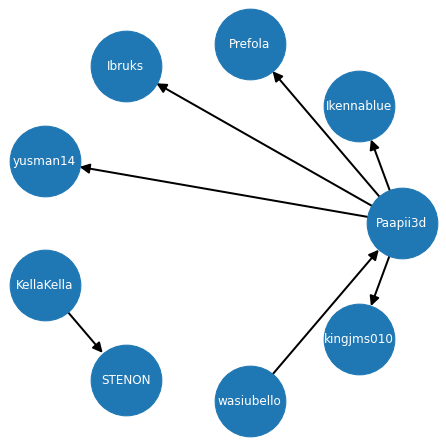

In [441]:
relationships = edges.head(7)
G = from_pandas_edgelist(relationships, source='source', target='target',
                         create_using=DiGraph())
plt.figure(figsize=(6,6))
draw(G, arrows=True, with_labels=True, pos=circular_layout(G),
    node_size=5000, node_color=None, font_color='white',
    width=2, arrowsize=20)

Our dataset probably has a few duplicate observations where `A` quotes `B` multiple times. We need no more than one instance of such interaction and will therefore eliminate duplicate observations. We will also symmetrize the edges so that we convert the graph into an undirected one. For our purposes, whether `A` quotes `B` or `B` quotes `A` is irrelevant. We only need confirmation of any interaction between `A` and `B`. This ensures that we obtain an adjacency matrix, $A$.

In [442]:
def getSymmetrizedDf(edges):
    edges_copy = edges.copy()
    edges_copy = edges_copy.rename(columns={'source': 'target','target':'source'})
    fedges = pd.concat([edges, edges_copy], axis=0)
    return fedges.drop_duplicates().reset_index(drop=True)
    
# Demo of your function:
relm = getSymmetrizedDf(edges)
relm.head()

,source,target
0,Paapii3d,Ikennablue
1,Paapii3d,Prefola
2,Paapii3d,Ibruks
3,Paapii3d,yusman14
4,KellaKella,STENON


We convert the dataframe into a sparse matrix where the entry is 1 if there is a relationship between `source` and `target`. Otherwise it is 0. The numerical ID of each node is determined from the `nodes` dataframe. The dimensions of the sparse matrix will be $n \times n$, where $n$ is 1 plus the largest ID in `nodes.index`.

In [519]:
nodes = pd.DataFrame(relm.source.unique()).rename(columns={0: 'name'})

In [520]:
def getSparseMatrix(nodes, edges):
    
    from scipy.sparse import coo_matrix
    n = nodes.index.max() + 1
    name_to_id = dict(zip(nodes['name'], nodes.index))
    values = np.ones(len(edges))
    rows = edges.source.apply(lambda x: name_to_id[x])
    cols = edges.target.apply(lambda x: name_to_id[x])
    A = coo_matrix((values, (rows, cols)), shape=(n,n))
    return A    


In [522]:
A = getSparseMatrix(nodes, relm)

In [521]:
A.shape

(167, 167)

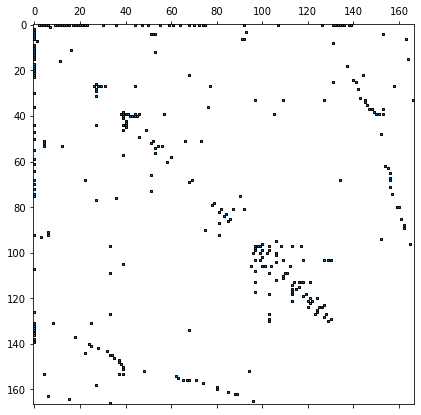

In [523]:
plt.figure(figsize=(7, 7))
plt.spy(A, markersize=2, markeredgecolor='black');

**Mining Relationships**. A plot of the sparse matrix shows the relationship existent between the nodes. Our objective is to cluster this relationship based on how connceted the nodes are. To realize this, we use the graph Laplacian, defined as $L = D - A$, where $A$ is the matrix of symmetrized relationships defined earlier and $D$ is the diagonal matrix consisting of the degree of every node. We use spectral graph partioning which is a graph partitioning technique based on the eigenvalues and eigenvectors of the Laplacian matrix of a graph to derive the communities present in the data.

The Laplacian is symmetric since it is derived from another symmetric matrix. Its eigenvalues are also non-negative. Its smallest eigenvalue is 0, but the second smallest and its corresponding eigenvector encode significant information about the relationship between the nodes in the matrix. We exploit this fact to cluster the nodes.

In [524]:
def partition_inds_by_sign(x):
    r_x = np.argwhere(x>0).flatten()
    l_x = np.argwhere(x<=0).flatten()
    return r_x, l_x

def invert_perm(k):
    return np.array(list(zip(*sorted(list(zip(np.arange(len(k)),k)), 
                                     key=lambda x: x[1])))[0])

In [525]:
def calc_fiedler_vector(A):
    from scipy.sparse import spdiags
    from scipy.sparse.linalg import eigsh
    n = min(A.shape)
    D = spdiags(A.sum(axis=1).reshape(n), diags=0, m=A.shape[0], n=A.shape[1])
    L = D - A # Laplacian
    _, V = eigsh(L, k=2, which='SM') # Determine 2nd smallest eigenpair
    return V[:, 1]

v = calc_fiedler_vector(A)

When data is partitioned using the fielder vector (corresponding eigenvector of second smallest eigenvalue), we form two groups. One from components with positive sign, and the other from components with non-positive sign. The plot below indicates how the fielder vector splits the data.

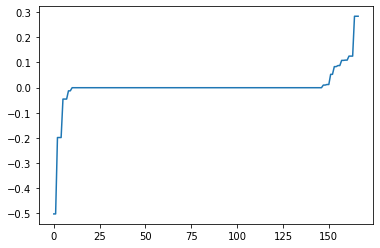

In [526]:
plt.plot(sorted(v));

In [527]:
k_g, k_l = partition_inds_by_sign(v)

print("=== Group 0 ===")
display(nodes.loc[k_g])

print("\n=== Group 1 ===")
display(nodes.loc[k_l])

=== Group 0 ===


,name
1,KellaKella
7,STENON
24,Adesuwa147
32,babajeje123
35,princesweetman2
48,Slymking
62,ssappsnwebs
63,eboigbedavid1
78,Raalsalghul
79,ges2019



=== Group 1 ===


,name
0,Paapii3d
2,wasiubello
3,drvalency
4,yusman14
5,sweetilicious
...,...
162,Vicogrin
163,Lolo24
164,IFIRI
165,Nonychinonso


We end up with two groups of data, which when plotted produce the relationship shown below

In [528]:
def reorder_by_fiedler(A, v):
    from scipy.sparse import coo_matrix
    assert isinstance(A, type(coo_matrix((1, 1))))

    r_v, l_v = partition_inds_by_sign(v)
    ind = np.concatenate((r_v, l_v))
    v_dict = dict(zip(ind, np.arange(len(ind))))
    
    A_n_row = [v_dict[i] for i in A.row]
    A_n_col = [v_dict[i] for i in A.col]
    
    A_perm = coo_matrix((A.data, (A_n_row, A_n_col)), shape=A.shape)
    return A_perm

    
A_perm = reorder_by_fiedler(A, v)

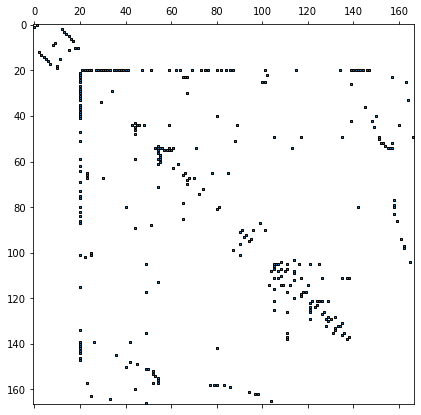

In [529]:
plt.figure(figsize=(7, 7))
plt.spy(A_perm, markersize=2, markeredgecolor='black')
plt.show()

The graph above shows the two groups inherent in the data based on interaction between posters. In this particular dataset, the main center of interaction is the original poster (OP) who is `Paapii3d`. The groups appear to be divided based on those who have or did not have interactions with the OP. When the individual groups are examined, we find that `Group 0` users are less likely to have interacted with `Paapii3d`, while users in `Group 1` are more likely to have interacted with the OP. The average number of interactions in `Group 0` is about 1.1, while the average number of interactions in `Group 1` is much higher at 2.12.

In [547]:
group0, group1 = [], []
for name in nodes.loc[k_g].values:
    group0.append(relm[relm['source'] == name[0]].count().loc['source'])

for name in nodes.loc[k_l].values:
    group1.append(relm[relm['source'] == name[0]].count().loc['source'])

In [546]:
print(f'Average number of interactions in Group 0 ==> {round(sum(group0) / group0.__len__(), 2)}')
print(f'Average number of interactions in Group 1 ==> {round(sum(group1) / group1.__len__(), 2)}')

Average number of interactions in Group 0 ==> 1.1
Average number of interactions in Group 1 ==> 2.12


## References

Weisstein, Eric W. "Spectral Graph Partitioning." From MathWorld--A Wolfram Web Resource. https://mathworld.wolfram.com/SpectralGraphPartitioning.html

Weisstein, Eric W. "Laplacian Matrix." From MathWorld--A Wolfram Web Resource. https://mathworld.wolfram.com/LaplacianMatrix.html

Sikdar, S. "Spectral Community Detection." Retrieved from https://www3.nd.edu/~kogge/courses/cse60742-Fall2018/Public/StudentWork/KernelPaperFinal/SCD-Sikdar-final.pdf